<h2>Business Understanding</h2>
<p>
<b>Problem:</b> Accurately predict company bankruptcy.<br>
<b>Objective:</b> Develop a model to identify companies at risk of bankruptcy early.<br>
<b>Constraints:</b> Ensure data quality, keep the model simple yet effective, avoid unfairness, and make sure it works efficiently in the real world.
</p>

In [47]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [48]:
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")

print("Path to dataset files:", path)
print("Path to dataset files:", path)
csv_file = None
for file in os.listdir(path):
    if file.endswith('.csv'):
        csv_file = os.path.join(path, file)
        break

if csv_file is None:
    print("No CSV file found in the directory.")
else:
    print(f"Found CSV file: {csv_file}")


Path to dataset files: C:\Users\keert\.cache\kagglehub\datasets\fedesoriano\company-bankruptcy-prediction\versions\2
Path to dataset files: C:\Users\keert\.cache\kagglehub\datasets\fedesoriano\company-bankruptcy-prediction\versions\2
Found CSV file: C:\Users\keert\.cache\kagglehub\datasets\fedesoriano\company-bankruptcy-prediction\versions\2\data.csv


In [49]:
df = pd.read_csv(csv_file, delimiter=',')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [51]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

<h2>X -> Independent features<br>
Y -> Dependent feature -> 0: Bankrupt; 1: Not Bankrupt</h2>

In [52]:
X_df=df.drop('Bankrupt?',axis=1)
Y_df=df['Bankrupt?']

<h4>Split data into training and testing sets</h4>

In [53]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2,random_state=42)


<h3>SMOTE (Synthetic Minority Over-sampling Technique) </h3>
<p>SMOTE is a technique used to address class imbalance by generating synthetic data points for the minority class.<br>
SMOTE generates synthetic data points for the minority class by interpolating between existing minority class samples and their nearest neighbors to balance the dataset.</p>

In [54]:
# Apply SMOTE to oversample the minority class
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train,  y_train)

<h3>Standardize numerical features</h3>

In [55]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

<h3>Principal Component Analysis (PCA)</h3>
<p>Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms data into a smaller set of uncorrelated variables (principal components), capturing the most significant variance in the dataset.<br><br>
Fit PCA and determine components( 85% of the variance)<br>Transform data using PCA<br>
Displays the explained variance for each component and its cumulative sum to understand how much of the original data variability is retained.<br>
Prints and plots loadings of the first principal component, showing the contribution of each feature to that component.</p>

Dimension of Training dataset: (5455, 95)
Dimension of Training dataset after applying PCA: (10572, 37)
[0.16682221 0.07258147 0.05463032 0.04216584 0.04029585 0.03190244
 0.03003174 0.02835773 0.02748409 0.0219037  0.01995538 0.01935328
 0.01781212 0.01735559 0.01570317 0.01553614 0.0141291  0.01397185
 0.0136169  0.012598   0.01211071 0.01189165 0.01182888 0.01141867
 0.01126623 0.01106157 0.01096337 0.01079953 0.01076172 0.01047314
 0.01035236 0.01024648 0.01007115 0.00966082 0.00948794 0.00920209
 0.00891614]
[0.16682221 0.23940368 0.29403399 0.33619983 0.37649568 0.40839812
 0.43842986 0.46678758 0.49427167 0.51617537 0.53613075 0.55548403
 0.57329615 0.59065174 0.60635491 0.62189106 0.63602016 0.64999201
 0.6636089  0.6762069  0.68831761 0.70020926 0.71203814 0.72345682
 0.73472305 0.74578462 0.75674799 0.76754752 0.77830924 0.78878238
 0.79913474 0.80938122 0.81945237 0.82911319 0.83860113 0.84780322
 0.85671935]
[[ 0.21329617  0.2116827   0.21031713 ...  0.00818928  0.
   0.071

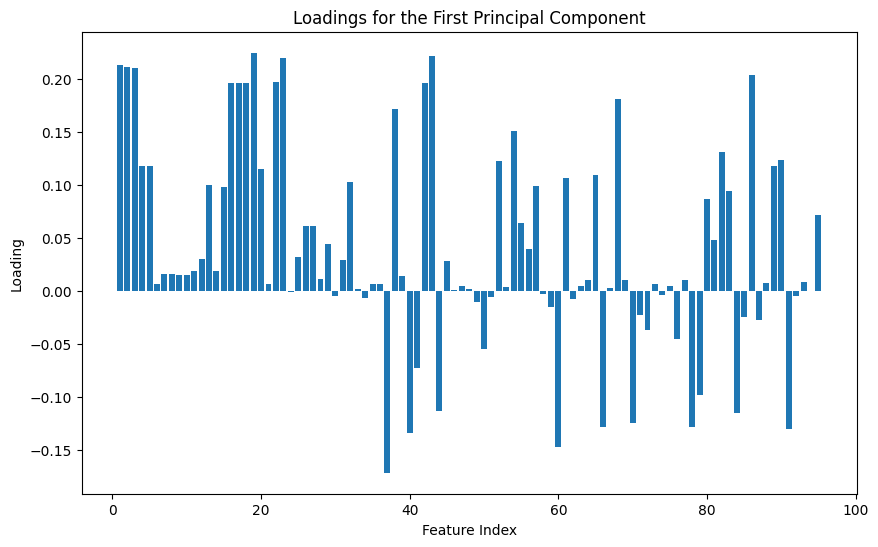

In [56]:
'''pca = PCA()
pca.fit(X_train_scaled)

threshold = 0.95
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= threshold) + 1'''
# Apply PCA with the chosen number of components
pca = PCA(n_components=0.85)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Dimension of Training dataset: {X_train.shape}')
print(f'Dimension of Training dataset after applying PCA: {X_train_pca.shape}')

# Choose the number of components to retain (e.g., to explain 95% of the variance)

print(f'{pca.explained_variance_ratio_}')
print(pca.explained_variance_ratio_.cumsum())

loadings = pca.components_
# Print the loadings
print(loadings)
# Visualize the loadings (e.g., for the first two principal components)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(loadings[0]) + 1), loadings[0])
plt.xlabel('Feature Index')
plt.ylabel('Loading')
plt.title('Loadings for the First Principal Component')
plt.show()


<h1>With K-Fold Cross Validation</h1>

Cross-validation accuracies for each fold: [0.89172577 0.90307329 0.91438032 0.89735099 0.89498581]
Mean cross-validation accuracy: 0.900303235661838
Test set accuracy: 0.870
Confusion Matrix:
[[1151  162]
 [  15   36]]


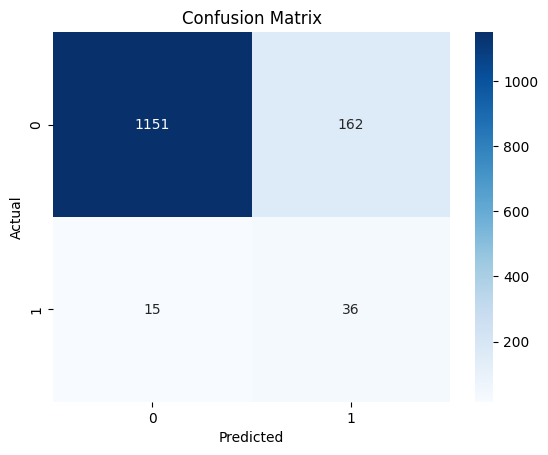

Accuracy: 87.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1313
           1       0.18      0.71      0.29        51

    accuracy                           0.87      1364
   macro avg       0.58      0.79      0.61      1364
weighted avg       0.96      0.87      0.90      1364



In [57]:
model = LogisticRegression()
# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(model, X_train_pca,  y_train_resampled, cv=kfold, scoring='accuracy')
# Print the cross-validation accuracy for each fold
print("Cross-validation accuracies for each fold:", cv_results)

# Print the mean accuracy across all folds
print("Mean cross-validation accuracy:", cv_results.mean())
# Train the model on the entire training set
model.fit(X_train_pca,  y_train_resampled)

# Test the model on the testing set and output accuracy
y_test_pred = model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


<h2>Model Building</h2><p>trains a logistic regression model<br> and evaluates its performance using a confusion matrix, accuracy, and a classification report.</p>
<h3>Confusion Matrix </h3><p>A confusion matrix is a table that summarizes the performance of a classification model on a set of test data</p>

<h1>Logistic Regression</h1>
<h3>With Stratified K-Fold Cross Validation</h3>
<p>Stratified K-Fold Cross-Validation is a technique used to ensure that the proportion of samples for each class is approximately equal in all folds, especially useful for imbalanced datasets. </p>

Cross-validation accuracies for each fold: [0.91070594 0.90808824 0.89794007 0.90316574 0.89064681]
Mean cross-validation accuracy: 0.9021093591186551
Test set accuracy: 0.870
Confusion Matrix:
[[1151  162]
 [  15   36]]


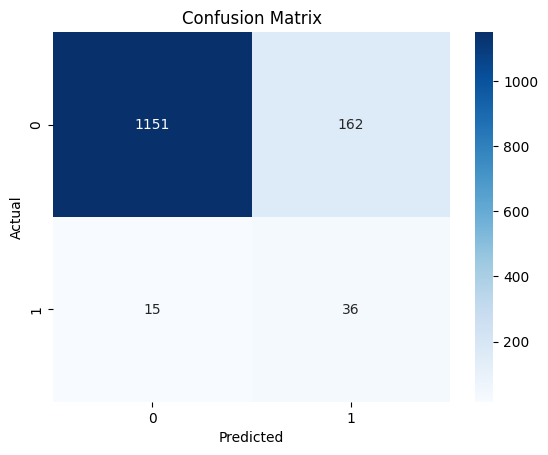

Accuracy: 87.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1313
           1       0.18      0.71      0.29        51

    accuracy                           0.87      1364
   macro avg       0.58      0.79      0.61      1364
weighted avg       0.96      0.87      0.90      1364



In [58]:
model = LogisticRegression()
# StratifiedKFold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(model, X_train_pca,  y_train_resampled, cv=stratified_kfold, scoring='f1')
# Print the cross-validation accuracy for each fold
print("Cross-validation accuracies for each fold:", cv_results)

# Print the mean accuracy across all folds
print("Mean cross-validation accuracy:", cv_results.mean())
# Train the model on the entire training set
model.fit(X_train_pca,  y_train_resampled)

# Test the model on the testing set and output accuracy
y_test_pred = model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


<p><b>True Positive (TP):</b> 36 instances were correctly predicted as bankrupt.<br>
<b>False Positive (FP):</b> 162 instances were incorrectly predicted as bankrupt.<br>
<b>False Negative (FN):</b> 15 instances were incorrectly predicted as non-bankrupt.<br>
<b>True Negative (TN):</b> 1151 instances were correctly predicted as non-bankrupt.<br>
</p>
<p><b>Precision:</b> The proportion of positive predictions that were actually positive.<br>
<b>For class 0 (non-bankrupt):</b> 99% of predicted non-bankrupt cases were actually non-bankrupt.<br>
<b>For class 1 (bankrupt):</b> 18% of predicted bankrupt cases were actually bankrupt.<br>
<b>Recall:</b> The proportion of actual positive cases that were correctly identified.<br>
<b>For class 0:</b> 88% of actual non-bankrupt cases were correctly identified.<br>
<b>For class 1:</b> 71% of actual bankrupt cases were correctly identified.<br>
<b>F1-score:</b> The harmonic mean of precision and recall, balancing both metrics.<br>
<b>Support:</b> The number of samples in each class.<br></p>
<p>

<h1>AUC-ROC</h1>It is used to evaluate the performance of a binary classification model.

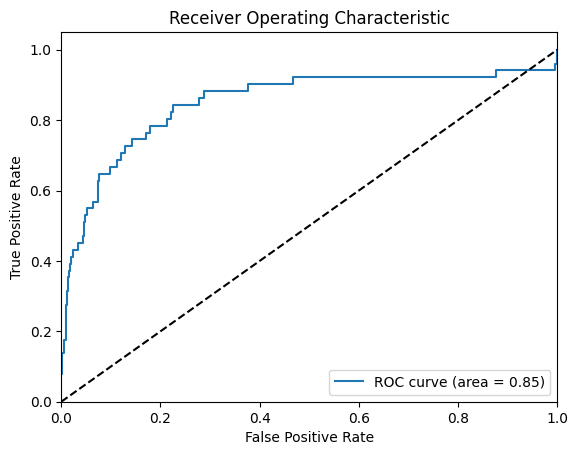

In [59]:
# Assuming you have your model, X_test, and y_test
y_pred_prob = model.predict_proba(X_test_pca)[:, 1]  # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<h1>Decision Tree</h1>

Test set accuracy: 0.910
Confusion Matrix:
[[1214   99]
 [  24   27]]


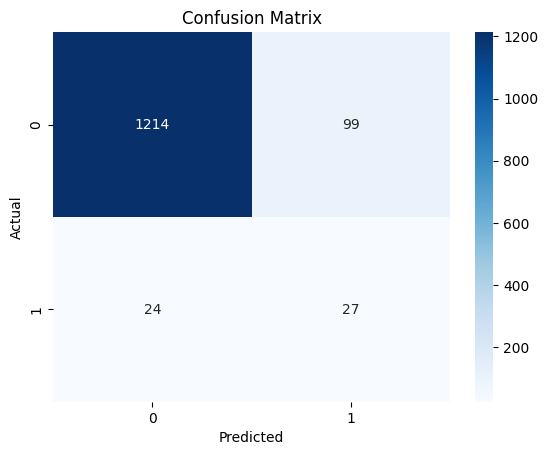

Accuracy: 90.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1313
           1       0.21      0.53      0.31        51

    accuracy                           0.91      1364
   macro avg       0.60      0.73      0.63      1364
weighted avg       0.95      0.91      0.93      1364



In [60]:
# Create a Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier() 
# Train the model
decision_tree_model.fit(X_train_pca, y_train_resampled)

# Make predictions on the test   set
y_test_pred = decision_tree_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


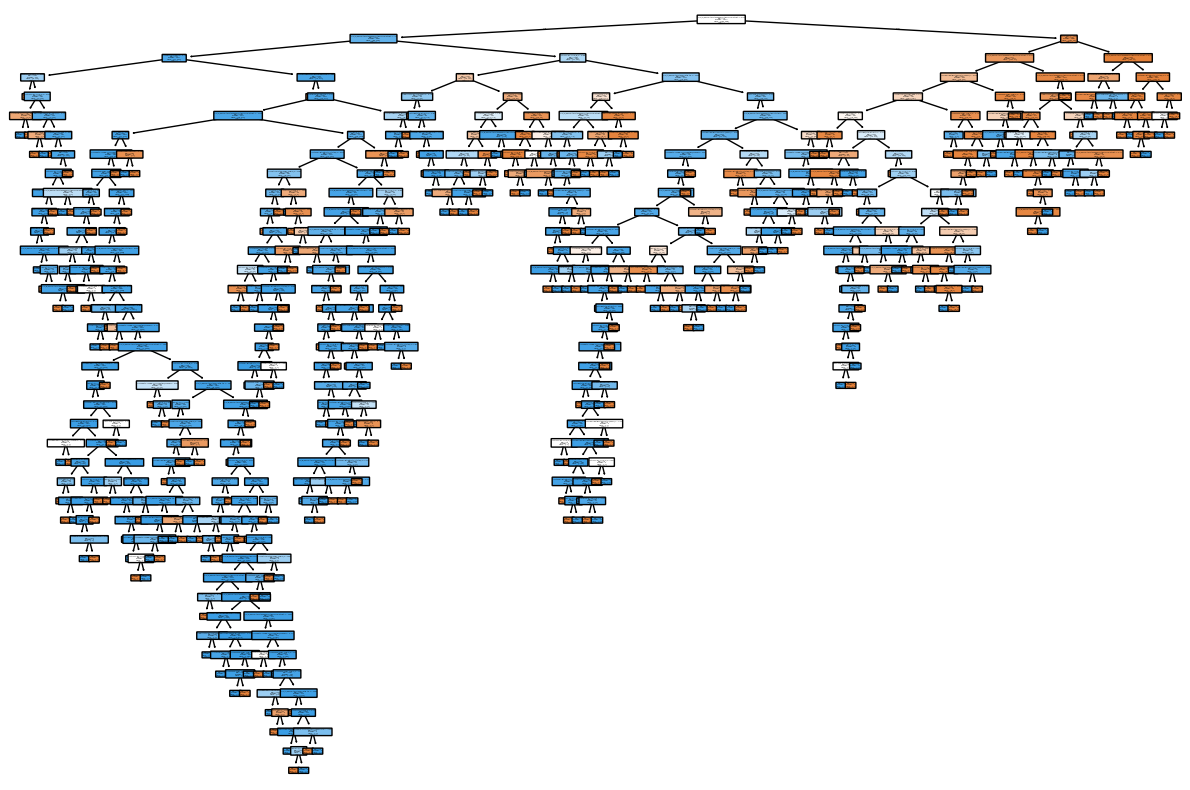

In [61]:
from sklearn import tree
import matplotlib.pyplot as plt

# ... (your existing code)
feature_names = list(X_df.columns)
# Convert integer class labels to strings (if necessary)
class_names = [str(class_name) for class_name in Y_df.unique()]

plt.figure(figsize=(15, 10))
tree.plot_tree(decision_tree_model, filled=True, rounded=True, feature_names=feature_names, class_names=class_names)
plt.show()

<h1>Random Forest</h1>

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Test set accuracy: 0.941
Confusion Matrix:
[[1260   53]
 [  28   23]]


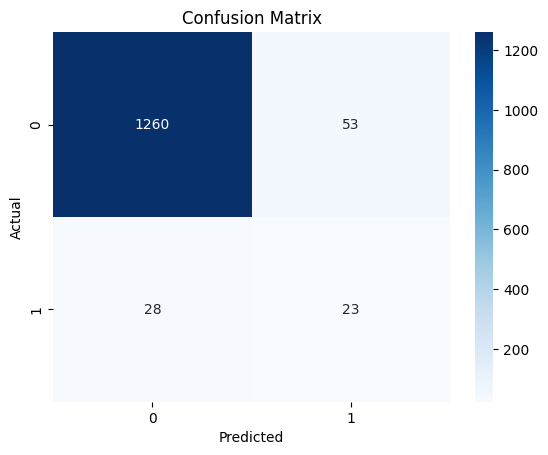

Accuracy: 94.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.30      0.45      0.36        51

    accuracy                           0.94      1364
   macro avg       0.64      0.71      0.67      1364
weighted avg       0.95      0.94      0.95      1364



In [70]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the  model
rf_classifier.fit(X_train_pca, y_train_resampled)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test_pca)
print(rf_classifier.get_params())
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


<h1>Hyperparameter Tuning</h1>
<p><b>n_estimators</b>  The number of trees in the forest.<br>
    <b>max_depth</b> The maximum depth of a tree<br>
    <b>min_samples_split</b> The minimum number of samples required to split an internal node.<br>
    <b>min_samples_leaf</b> The minimum number of samples required to be at a leaf node.<br></p>

{'max_depth': 30, 'n_estimators': 150}
0.9778654517558278
Test set accuracy: 0.942
Confusion Matrix:
[[1261   52]
 [  27   24]]


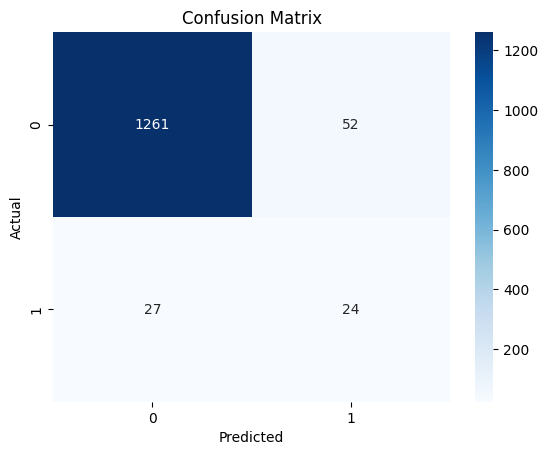

Accuracy: 94.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.32      0.47      0.38        51

    accuracy                           0.94      1364
   macro avg       0.65      0.72      0.67      1364
weighted avg       0.95      0.94      0.95      1364



In [71]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50,100,120,150,180,200],
    'max_depth': [5, 10, 15,20,30,50,75,100],
   }

# Create a Random Forest Classifier
rf_hypertuning = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_hypertuning, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_pca, y_train_resampled)

# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_test_pred= best_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

<p><b>Logistic Regression: </b>Accuracy: 87.02%<br>
<b>Decision Tree: </b>Accuracy: 90.98%<br>
<b>Random Forest:</b> Accuracy: 94.06%<br>
<b>Random Forest With HyperParameter Tuning:</b> Accuracy: 94.21%<br></p>